# Getting Started with OpenMM

## Introduction

OpenMM is a high-performance toolkit for molecular dynamics simulations.  This series of tutorials is designed to walk you through the basic steps of using OpenMM to set up and run simulations.  Once you have familiarized yourself with these basics, you can consult the [list of more advanced tutorials](../../tutorials.rst#beyond-the-basics) to learn how to accomplish more specific simulation tasks.

Before beginning, it is useful to understand a bit about the architecture of OpenMM.  The core OpenMM library is written in C++, and the [OpenMM C++ API](https://docs.openmm.org/latest/api-c++/) can be used directly to invoke OpenMM from C++ programs.  However, OpenMM provides wrappers for other languages as well, such as the [OpenMM Python API](https://docs.openmm.org/latest/api-python/).  These tutorials demonstrate how to use OpenMM from its Python API, not only for the convenience of working with OpenMM *via* Python, but also because some features are only available from Python.  In particular, the Python API consists of both:

* A lower-level ["library layer"](https://docs.openmm.org/latest/api-python/library.html) that directly wraps OpenMM's C++ interface and provides tools for building customized molecular simulation scripts, libraries, and applications from scratch, and
* A higher-level ["application layer"](https://docs.openmm.org/latest/api-python/app.html) that provides various tools for loading and applying commonly used molecular force fields, reading and writing common trajectory and topology file formats, and reporting properties during simulation runs.

In general, there are three primary methods of using OpenMM to set up and run molecular simulations:

1. Load a molecular topology, use OpenMM to modify it as needed, parameterize it with a force field, and simulate it.  This is the simplest method to perform straightforward simulations of biomolecules in OpenMM.  For example, if you have a PDB file with the structure of a particular protein, and you want to solvate it and simulate it with a standard Amber or CHARMM force field, this is the easiest method to do so.  This method uses OpenMM's application layer.
2. Use some external programs or tools (*e.g.*, LEaP from [AmberTools](https://ambermd.org/AmberTools.php), or [CHARMM-GUI](https://www.charmm-gui.org/), to do your modeling and parameterization, and load the resulting input files into OpenMM for simulation.  This method can be convenient if your desired modeling workflow is more complex than what OpenMM currently supports, or you wish to use a force field that hasn't been ported to OpenMM's native format.  It also uses OpenMM's application layer.
3. Use OpenMM's library layer to build a molecular system from scratch.  This is the most general and flexible way to use OpenMM, but requires you to explicitly define all of the necessary potential energy terms and parameters for the atoms, bonds, angles, torsions, *etc.* in your simulation, unlike the other methods that handle this setup automatically given a topology and a predefined force field.  This approach can be useful to build more complex systems when complete control over system setup is required.  However, it is also especially helpful for setting up simulations of simple model systems like Lennard-Jones fluid mixtures, bead-spring polymers, or simple coarse-grained models.

These approaches are not completely exclusive: for instance, it is possible to use OpenMM's application layer to set up a simulation, and then use the library layer to make manual modifications before running it.  However, understanding the basics of these methods is useful for understanding how to build more complex simulation workflows with OpenMM, so these introductory tutorials will walk through each of them in turn.  This first tutorial covers the first method.  In particular, we will see how to load a protein structure into OpenMM, clean up and prepare the structure for simulation, specify a force field, and run a simulation.

The tutorials will not describe in extensive detail the use of external programs, such as Amber and CHARMM, for system setup.  When they discuss how to use OpenMM to run simulations that have been set up using other tools, links to relevant documentation for these tools will be given.  Furthermore, they will not describe in detail the basic theory behind molecular simulations, or discuss how to perform more advanced analysis of simulation results beyond extracting basic thermodynamic properties.  For links to resources on related topics not covered directly in these tutorials, refer to the [Further Reading](#Further-Reading) section of this and other tutorial notebooks.

## Installing OpenMM and Running OpenMM Setup

The most straightforward ways to install OpenMM are through either [conda-forge](https://anaconda.org/conda-forge/openmm) or [PyPI](https://pypi.org/project/OpenMM/).  If you are using `conda`, then
```shell
conda install -c conda-forge openmm
```
is all you need to get started, but more detailed instructions and a more comprehensive list of installation options can be found [in the OpenMM user manual](https://docs.openmm.org/latest/userguide/application/01_getting_started.html#installing-openmm).  (If you are following along with this notebook in Google Colab, then a cell has been inserted at the top of the notebook with commands to automatically install OpenMM into the Colab environment.)

Unlike some other molecular dynamics packages (*e.g.*, LAMMPS), an installation of OpenMM does not include a standalone executable that reads input files with parameters and commands, runs simulations, and writes results.  Instead, OpenMM simply includes a Python package `openmm` providing access to its API.  This allows you to write "input scripts" for OpenMM in Python by importing its package and using the classes and functions it provides, while also enabling the use of OpenMM as a library inside more complex Python packages and programs.

For this tutorial, where we load a protein structure and set up a straightforward molecular dynamics simulation, we will only need to write a simple script.  OpenMM provides a helpful utility, called [OpenMM Setup](https://github.com/openmm/openmm-setup), to automate writing the necessary Python scripts for simulation tasks like this.  It can be installed as an additional conda-forge package:
```shell
conda install -c conda-forge openmm-setup
```
(If you haven't already installed the `openmm` package, the `openmm-setup` package will automatically install it as a dependency.)  OpenMM Setup can be started by running the command
```shell
openmm-setup
```
in a shell, which opens its graphical user interface in a web browser.

<img src="getting_started_1.png" width="800" style="border: 1px solid black;" />

In this example, we will use a structure of hen egg white lysozyme from the Protein Data Bank with [PDB ID 1AKI](https://www.rcsb.org/structure/1AKI).  The structure can be downloaded in PDBx/mmCIF format as [1AKI.cif](https://files.rcsb.org/download/1AKI.cif) from the linked PDB entry.  If you want to follow along in OpenMM Setup, you can select the default option to load a PDB or PDBx/mmCIF file.

<img src="getting_started_2.png" width="800" style="border: 1px solid black;" />

To actually perform any kind of simulation from a molecular structure, we need to specify a *force field* that defines parameters for bonded and non-bonded interactions between its atoms, thereby allowing OpenMM to compute energies and forces from atomic positions.
OpenMM provides several commonly used force fields for biomolecular simulations; these are [described in the user guide](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#force-fields).  Choosing an appropriate force field for your research problem is outside of the scope of this tutorial, but you should be aware of the behavior of the force field you choose and any limitations it has that might be applicable to your system.  The default force field that we will use here, which OpenMM refers to as ["Amber19"](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#amber19), includes Amber [ff19SB](https://ambermd.org/AmberModels_proteins.php) force field parameters for proteins, among others.  For this tutorial, we will use the default TIP3P-FB model for water; the water models distributed with the force fields built into OpenMM also contain compatible parameters for ions.

Protein structures downloaded directly from the Protein Data Bank are often not immediately suitable for running simulations.  They may be missing hydrogen atoms, and they may contain additional, *e.g.*, oxygen atoms at positions where water molecules are found in the crystal structures.  OpenMM Setup comes with a builtin interface to the [PDBFixer](https://github.com/openmm/pdbfixer) tool that can help clean up and prepare files for simulation.  Selecting the option to do this leads to a visualization window where we can inspect the structure and choose actions to take:

<img src="getting_started_3.png" width="800" style="border: 1px solid black;" />

A PDB or PDBx/mmCIF file contains a hierarchical representation of a molecular structure, with atoms grouped into residues and residues grouped into chains.  Chains can correspond to single polymeric molecules consisting of a sequence of residues, but more generally, a chain may just group related residues together.  For the file we are using in this tutorial, the protein is present in chain A and all of the crystallographic water molecules are in chain B, so we can exclude the latter to remove the water molecules.  Alternatively, you can use the "delete heterogens" dropdown to remove water as well as other non-standard species from the structure.

After removing the water present in the crystal structure, we can instruct OpenMM Setup to add hydrogen atoms to the remaining protein, and add water back (along with $\ce{Na+}$ and $\ce{Cl-}$ ions) in the form of a solvent box surrounding it.  Here we have kept the default options except for increasing the ionic strength to 0.1 M:

<img src="getting_started_4.png" width="800" style="border: 1px solid black;" />

At last, OpenMM Setup will generate a Python script along with a PDBx/mmCIF file containing our preprocessed and solvated protein structure.  You can use OpenMM Setup to run OpenMM and monitor the simulation output directly from your web browser, but in this tutorial, we will take the script that OpenMM Setup generates and work through it line by line.  For this tutorial, we will keep the default options from OpenMM Setup, except for:

* Decreasing the value of the "Simulation Length (steps)" field in the Simulation tab to 10000 (for convenience running the simulation within a Jupyter notebook).
* Changing the "Platform" option in the Simulation tab to "CPU".  If you are running OpenMM on a computer with a GPU that supports CUDA or OpenCL, you can select the appropriate option to instruct OpenMM to use your GPU for increased performance.
* Deselecting the "Save trajectory to a file" and "Save checkpoints to a file" options in the Output tab.  The next tutorial will cover simulation output from OpenMM in more detail; in this tutorial, we will just instruct OpenMM to write some basic statistics to a text file.
* Decreasing the value of the "Data Output Interval (steps)" field in the Output tab to 100.  Since we have selected a shorter simulation length, we can save simulation properties more frequently for convenience.
* Selecting "Density" under "Data to Write" in the Output tab.  Since the default is to run a simulation at constant pressure, this will allow us to monitor changes in the volume of the system.

If you are following along with OpenMM Setup, you should select "Save All Files" to save the generated Python script and preprocessed structure `1AKI-processed.cif`.  If you are running this tutorial as a Jupyter notebook locally in Google Colab, the necessary PDBx/mmCIF file is already provided.  The Python script generated by OpenMM Setup with the options described above set should look like:

```python
# This script was generated by OpenMM-Setup on 2025-09-19.

from openmm import *
from openmm.app import *
from openmm.unit import *

# Input Files

pdbx = PDBxFile('1AKI-processed.cif')
forcefield = ForceField('amber19-all.xml', 'amber19/tip3pfb.xml')

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 10000
equilibrationSteps = 1000
platform = Platform.getPlatformByName('CPU')
dataReporter = StateDataReporter('log.txt', 100, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, density=True, separator='\t')

# Prepare the Simulation

print('Building system...')
topology = pdbx.topology
positions = pdbx.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)

# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate

print('Simulating...')
simulation.reporters.append(dataReporter)
simulation.currentStep = 0
simulation.step(steps)
```

## Running a Simulation

We will now examine the Python script generated by OpenMM Setup in detail.  First, we import OpenMM:

In [1]:
from openmm import *

Importing the top-level module only gives access to the [library layer](https://docs.openmm.org/latest/api-python/library.html) of the Python API.  To access the [application layer](https://docs.openmm.org/latest/api-python/app.html) that we will primarily be using in this tutorial, and OpenMM's units API that we will discuss later, we can use:

In [2]:
from openmm.app import *
from openmm.unit import *

(When using OpenMM as part of a more complex workflow, you may want to import just the names you need, or just these packages, instead of using `from ... import *`, but the latter is convenient for simple scripts like this.)

### Input Files

Now we can load the PDBx/mmCIF file generated by OpenMM Setup using the [PDBxFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.pdbxfile.PDBxFile.html) class:

In [3]:
pdbx = PDBxFile('1AKI-processed.cif')

OpenMM supports loading [several other kinds](https://docs.openmm.org/latest/api-python/app.html#loaders-and-setup) of commonly used file formats, including, for example, files in the legacy (but ubiquitous) PDB format using [PDBFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.pdbfile.PDBFile.html).

We also need to load the force field we have chosen into OpenMM.  To do this, we can create a [ForceField](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html) object with paths to XML files that define the templates and parameters for the force field:

In [4]:
forcefield = ForceField('amber19-all.xml', 'amber19/tip3pfb.xml')

We do not need to find and place these files in the current working directory to load them.  OpenMM tries to look up the force field files using the paths provided first, and if they cannot be found, looks in its data directories for them.  Since we are using force fields that are [distributed with OpenMM](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#force-fields), they are loaded from the data directory that can be found at `openmm/app/data` wherever the OpenMM Python API has been installed.

### Simulation Parameters

The script generated by OpenMM Setup now defines several constants specifying simulation parameters.  We will discuss each of these in more detail as they are used.  OpenMM Setup allows you to adjust all of their values, although the defaults it generates should usually be appropriate for biomolecular simulations.

In [5]:
# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 10000
equilibrationSteps = 1000

You may notice that some of these parameters are quantities with units.  OpenMM's Python API supports automatic unit conversions and dimension checking through the [openmm.unit](https://docs.openmm.org/latest/api-python/app.html#units) package.  If raw values without units are provided to OpenMM, it will assume that they are appropriately dimensioned quantities in OpenMM's [default unit system](https://docs.openmm.org/latest/userguide/theory/01_introduction.html#units).  However, always using the units API can help prevent unit conversion mistakes.  More information can be found [in the user guide](https://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#units-and-dimensional-analysis).

Next, OpenMM Setup explicitly selects the OpenMM [Platform](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Platform.html) to use.  This controls (among other things) whether calculations are done on the CPU or the GPU.  Platform selection is discussed [in the user guide](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#platforms), as well as the [differences between platforms](https://docs.openmm.org/latest/userguide/library/01_introduction.html#platforms) provided by OpenMM.  Depending on the hardware and drivers installed, not every platform may be usable.  If you do not choose a platform manually, OpenMM will attempt to select the fastest one available.

In [6]:
platform = Platform.getPlatformByName('CPU')

Now we can create a [StateDataReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html) that will print some basic information about the state of our simulation to a file as it runs.  As already mentioned, we will explore options for output in more detail in the next tutorial.

In [7]:
dataReporter = StateDataReporter('log.txt', 100, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, density=True, separator='\t')

### Preparing the Simulation

The PDBxFile object produced by loading the file above has a `topology` attribute containing an OpenMM [Topology](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html) object, and a `positions` attribute, holding the actual coordinates contained in the file.

In [8]:
topology = pdbx.topology
positions = pdbx.positions

Topology objects contain information about the identity and connectivity of the particles in a molecular system.  They arrange this information hierarchically, with each Topology containing a list of chains, each chain a list of residues, and each residue a list of atoms.  For biopolymers such as proteins, OpenMM's concepts of chains and residues generally map onto their standard meanings in this context.  In a later tutorial, we will look at this structure in more detail and see how to build a Topology manually.

For now, we will use the Topology as is with the [ForceField.createSystem()](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html#openmm.app.forcefield.ForceField.createSystem) method to create an OpenMM [System](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html).  In contrast to a ForceField, which defines interaction parameters for atoms in *residue templates*, a System object contains information about all of the interactions that OpenMM needs to calculate energies and forces for our actual molecular system of interest.  OpenMM looks at the residues in the Topology, matches them to templates in the ForceField, and assigns parameters to create the final System.

In [9]:
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)

In addition to the Topology, OpenMM Setup passes several options to createSystem():
- `nonbondedMethod`: Specifies [how OpenMM should compute nonbonded interactions](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#nonbonded-interactions).  `PME` is the particle mesh Ewald method, which is usually preferable when the system you are simulating has charges and uses periodic boundary conditions.
- `nonbondedCutoff`: Specifies a cutoff distance for Lennard-Jones interactions, and controls the splitting between Coulomb interactions computed in direct *vs.* reciprocal space.  More information about the theory used by OpenMM to compute these interactions can be found in the [user guide](https://docs.openmm.org/latest/userguide/theory/02_standard_forces.html#nonbondedforce).
- `constraints`: Controls which interparticle distances in a simulation OpenMM will apply rigid constraints to.  The `HBonds` option selects all bonds to hydrogen atoms, which typically have large force constants and thus generate high-frequency motion.  Constraining them to fixed distances allows the simulation to use a larger timestep while still remaining stable.
- `rigidWater`: Controls application of rigid constraints specifically to water molecules in the simulation.
- `ewaldErrorTolerance`: Controls the relative error in computing forces due to electrostatics with the Ewald method.  The value of 0.0005 selected by OpenMM Setup is the default used by OpenMM if none is specified.
- `hydrogenMass`: Controls the mass of hydrogen atoms used for [hydrogen mass repartitioning](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#heavy-hydrogens), which can permit a further increase in the simulation timestep.

For simulations in the NPT ensemble, we need to control both the pressure and the temperature.  For pressure control, OpenMM offers the [MonteCarloBarostat](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.MonteCarloBarostat.html), which attempts to uniformly scale the size of the simulation's periodic box vectors every `barostatInterval` steps.  (Other, anisotropic barostats are also available.)

In [10]:
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval));

Note that in addition to the desired `pressure`, we must also pass the system `temperature` to the barostat so that it can calculate the correct probability that a volume adjustment Monte Carlo move should be accepted.  This barostat does not also control the temperature, but instead must be used in conjunction with a thermostat.

To perform molecular dynamics simulations, we need to select an integration algorithm.  In OpenMM, we do so by creating an [Integrator](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Integrator.html) object.  Subclasses of Integrator define specific integration algorithms.  Here, we will use the [LangevinMiddleIntegrator](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html), which uses Langevin dynamics to integrate positions and velocities over time and maintain temperature at a fixed setpoint:

In [11]:
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)

We also set the `friction` coefficient for the integrator, and specify the simulation timestep `dt`.  The `constraintTolerance` controls the error in satisfying any rigid distance constraints in the System.  Choosing appropriate integration parameters is beyond the scope of this tutorial, but the values selected by OpenMM Setup should be reasonable for biomolecular simulations.

We now have all of the pieces in place needed to run a simulation, and can create an OpenMM [Simulation](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html) object that will manage the simulation for us:

In [12]:
simulation = Simulation(topology, system, integrator, platform)

The simulation holds a `context` attribute containing an OpenMM [Context](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html).  Unlike a System, which just defines information about particles and the interactions between them, a Context stores all of the information about the state of a simulation, including particle positions and velocities.  A System object acts somewhat like a template for creating Context objects, and one System could be used to create more than one Context if desired.  The interaction parameters, and other properties, stored in a Context are dependent on the parameters set in the System when the Context was created.  If changes are made to a System after a Context has been created from it, the Context will not automatically reflect these changes (although in certain cases, it is possible to update a Context with new parameters from a System).

You may have noticed that we only used the `topology` from our PDBxFile, and not its `positions`, when creating the System.  Now that we have a Context, we can initialize it with the positions from the PDBxFile.

In [13]:
simulation.context.setPositions(positions)

Although there should not be severe problems like overlapping particles in our initial positions, it is a good idea to run a local energy minimization before starting a simulation.  The distances between protein atoms from the PDB structure might differ from their equilibrium values defined by the force field, and the solvent molecules added by OpenMM Setup might not have optimal orientations.  Minimizing the energy can prevent large initial forces that could otherwise destabilize a simulation.  OpenMM makes this easy to do:

In [14]:
simulation.minimizeEnergy()

With good initial positions determined, we can now set initial velocities by having OpenMM draw from the appropriate random distribution:

In [15]:
simulation.context.setVelocitiesToTemperature(temperature)

### Running Steps

At last, we can run some simulation steps.

In [16]:
simulation.step(equilibrationSteps)

If you are interested in the equilibrium properties of a system, it is a good idea to run the simulation for an equilibration period, as we have just done, before collecting data.  For an actual production simulation, you will generally need to run for longer than the 4 picoseconds we have integrated over here.  In any case, to monitor its progress, we can attach the StateDataReporter we previously created to the Simulation:

In [17]:
simulation.reporters.append(dataReporter)

Resetting the step counter and running more steps will now result in periodic output to a file `log.txt`:

In [18]:
simulation.currentStep = 0
simulation.step(steps)

We have now reached the end of the script generated by OpenMM Setup, but it is worth inspecting the output generated.  The format of the data file written by the StateDataReporter is very simple:

In [19]:
!head log.txt

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"	"Speed (ns/day)"
1.0%	100	-372339.6674590541	303.5917720396911	1.009710488275946	0
2.0%	200	-371376.00580265385	298.5854126266576	1.009710488275946	41.8
3.0%	300	-370829.8342904054	296.56965522111864	1.009710488275946	41.7
4.0%	400	-372141.6384225179	300.2108810039406	1.0126252010127539	41.4
5.0%	500	-371538.85643481585	296.516448283497	1.013533186652472	42
6.0%	600	-372357.9965373707	301.28547078768406	1.014537407448307	41.9
7.0%	700	-372491.67199361994	303.9711391440828	1.0158236184528664	41.9
8.0%	800	-372239.01041248353	303.54926429728386	1.0122187507525564	41.7
9.0%	900	-371462.2029534025	302.6352533429284	1.014700490215549	41.6


We can plot the results to qualitatively assess how these parameters change with time:

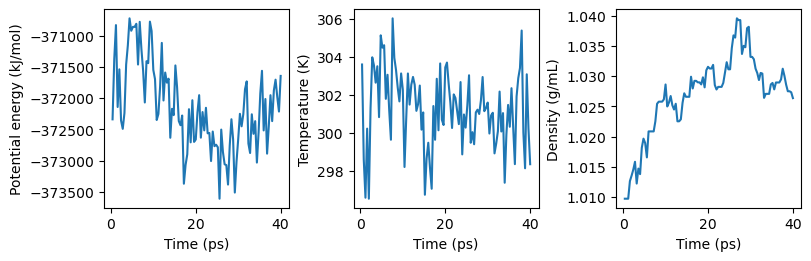

In [20]:
import numpy
import matplotlib.pyplot

step, pe, temp, rho = numpy.loadtxt("log.txt", delimiter="\t", usecols=(1, 2, 3, 4)).T
time = step * dt.value_in_unit(picosecond)

figure = matplotlib.pyplot.figure(figsize=(8, 2.5), layout="constrained")

axes_pe = figure.add_subplot(1, 3, 1)
axes_pe.plot(time, pe)
axes_pe.set_xlabel("Time (ps)")
axes_pe.set_ylabel("Potential energy (kJ/mol)")

axes_temp = figure.add_subplot(1, 3, 2)
axes_temp.plot(time, temp)
axes_temp.set_xlabel("Time (ps)")
axes_temp.set_ylabel("Temperature (K)")

axes_rho = figure.add_subplot(1, 3, 3)
axes_rho.plot(time, rho)
axes_rho.set_xlabel("Time (ps)")
axes_rho.set_ylabel("Density (g/mL)")

matplotlib.pyplot.show()

The fluctuations in the potential energy and temperature here appear mostly random, while the density is still increasing at the start of the run, suggesting an insufficient equilibration time.  Of course, in a production run, longer simulations would be used, along with more advanced analysis to understand whether or not the structure of the protein is changing over time.  The simulation is intentionally kept short for this tutorial, and more complex analysis is out of its scope.

## Summary

After following this tutorial, you should now be able to:

* Perform basic structure preparation tasks, like adding hydrogen atoms and a solvent box, in OpenMM Setup.
* Load a PDBx/mmCIF file into OpenMM, set up a simulation at constant temperature and pressure, and run an energy minimization.
* Run molecular dynamics steps and set up OpenMM to write basic thermodynamic properties to an output file.

We used OpenMM Setup to prepare our input structure as well as generate an input script.  If you want to do this programmatically from within Python, rather than through the OpenMM Setup graphical user interface, you may be able to use OpenMM's [Modeller](https://docs.openmm.org/latest/api-python/generated/openmm.app.modeller.Modeller.html) class: see the [user guide](https://docs.openmm.org/latest/userguide/application/03_model_building_editing.html) for examples.  In addition, the [PDBFixer](https://github.com/openmm/pdbfixer) tool, used internally by OpenMM Setup, offers various options for fixing common problems in structures from the Protein Data Bank.

In the next tutorial, we will discuss various ways of getting data in and out of OpenMM.  We will cover how to read input files in formats designed for other molecular dynamics engines like Amber, and how to get various kinds of data, including simulation trajectories, out of OpenMM while running a simulation.

## Further Reading

* Relevant sections of the [User Guide](https://docs.openmm.org/latest/api-python/):
  * [Chapter 3: Running Simulations](https://docs.openmm.org/latest/userguide/application/02_running_sims.html)
  * [Section 12.3: Python API](https://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#python-api)
* [Python API documentation](https://docs.openmm.org/latest/api-python/) pages for classes used in this tutorial:
  * [ForceField](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html)
  * [LangevinMiddleIntegrator](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html)
  * [MonteCarloBarostat](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.MonteCarloBarostat.html)
  * [PDBxFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.pdbxfile.PDBxFile.html)
  * [Platform](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Platform.html)
  * [Simulation](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html)
  * [StateDataReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html)
* Troubleshooting basics:
  * If you cannot even `import openmm` from Python, make sure that you have followed the [installation instructions](https://docs.openmm.org/latest/userguide/application/01_getting_started.html#installing-openmm) carefully.
  * If you can import OpenMM in Python, but are encountering problems running simulations, the OpenMM [Frequently Asked Questions](https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions) discusses some common errors and how to resolve them.
  * If the documentation does not address the problem you are having, feel free to ask for help on the OpenMM [discussion board](https://github.com/openmm/openmm/discussions).